In [1]:
import sys
sys.path.append('../src')
from utils import *
from tqdm import tqdm
import numpy as np
import torch
import matplotlib.pyplot as plt
from sparse_coding_model import SparseCoding, normalize01
rng = np.random.default_rng()

## Read data

In [2]:
adult = np.load('../adult_songs/data.npz')
n_samples, n_syl, n_freq_bins, n_time_bins = adult['spec_syl'].shape
pert_syl_idx = adult['pert_syl_idx']

# adult song used for training
MASK_ADULT_TEST = np.zeros(n_samples).astype(np.bool)
MASK_ADULT_TEST[rng.choice(np.arange(n_samples), size=n_samples//3*2, replace=False)] = True
adult_train = torch.tensor(adult['spec_syl'][~MASK_ADULT_TEST], dtype=torch.float32)
adult_train = torch.concatenate([_ for _ in adult_train])

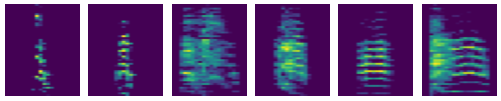

In [3]:
fig, ax = plt.subplots(1, n_syl, sharex='all', sharey='all', figsize=(5, 1))
for i in range(n_syl):
    ax[i].imshow(adult['spec_syl'][1,i], origin='lower', aspect='auto')
    ax[i].set_axis_off()
# fig.savefig('../svg/adult_spec.svg')

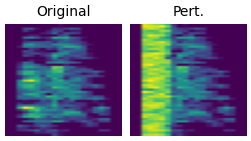

In [4]:
fig, ax = plt.subplots(1, 2, sharex='all', sharey='all', figsize=(2.5, 1.4))
for i, j in enumerate(('Original', 'Pert.')):
    ax[i].set_axis_off()
    ax[i].set_title(j)
ax[0].imshow(adult['spec_syl'][1,adult['pert_syl_idx']])
ax[1].imshow(adult['spec_syl_pert'][1][1], origin='lower', aspect='auto')
# fig.savefig('../svg/adult_spec_pert.svg')

## Model Training

In [5]:
net = SparseCoding(n_basis=100, n_freq_bins=n_freq_bins, n_time_bins=n_time_bins, lam=3)
EPOCH = 300
dBs, sparsity = [], []

In [6]:
for epoch in tqdm(range(EPOCH), disable=False):
    a, dB = net(adult_train, train=True)
    a = a.numpy()
    dBs.append(dB)
    sparsity.append((np.abs(a) > a.std()).mean())
    # print('[%d] dB = %.3E, sparsity = %.3E' % (epoch, np.mean(aux_dB), np.mean(aux_sp)))

100%|██████████| 300/300 [00:07<00:00, 38.34it/s]


[Text(0, 0.5, 'Loss'), Text(0.5, 0, 'Step')]

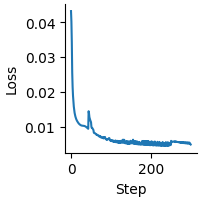

In [7]:
fig, ax = plt.subplots(1, figsize=(2, 2))
ax.plot(np.vstack(dBs))
ax.set(ylabel='Loss', xlabel='Step')

In [8]:
# torch.save(net.basis, 'net_params.pkl')

In [9]:
# net.basis = torch.load('net_params.pkl')

### Learned filters

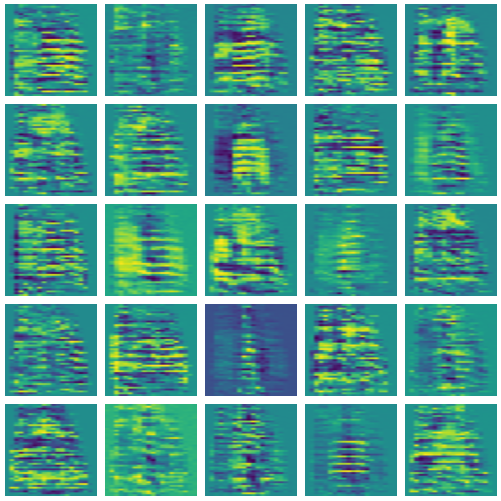

In [10]:
fig, ax = plt.subplots(5, 5, figsize=(5,5))
ax = ax.flatten()
for i in range(len(ax)):
    ax[i].imshow(net.basis[:,i].detach().reshape(net.n_freq_bins, net.n_time_bins).numpy(), 
                 aspect='auto', interpolation='antialiased', origin='lower')
    ax[i].set_axis_off()
# fig.savefig('../svg/supplementary/learned_filters.svg')

### Check reconstructions

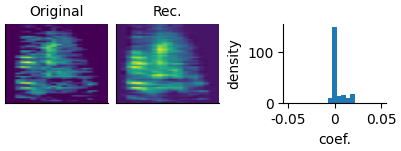

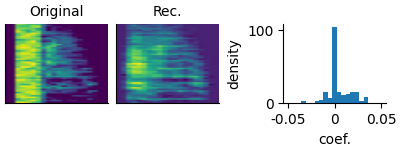

In [11]:
# sanity check
t0 = 0
i = 0 # idx of the syl to plot
x0s = [adult['spec_syl'][i,pert_syl_idx], adult['spec_syl_pert'][1][i]]
xs = [torch.tensor(adult['spec_syl'][:,pert_syl_idx], dtype=torch.float32),
      torch.tensor(adult['spec_syl_pert'][1], dtype=torch.float32)]
for j, x in enumerate(xs):
    a = net(x[i], n_iter_coef=200)
    a = a.numpy()
    fig, ax = plt.subplots(1, 3, figsize=(4, 1.5))
    rec = net.basis.detach().numpy() @ a[i]
    ax[0].imshow(x0s[j], origin='lower')
    ax[1].imshow(rec.reshape(net.n_freq_bins, net.n_time_bins), origin='lower')
    ax[2].hist(a.flatten(), bins=21, density=True, range=(-0.05, 0.05))
    ax[0].set(xticks=[], yticks=[], title='Original')
    ax[1].set(xticks=[], yticks=[], title='Rec.')
    ax[2].set(xticks=[-0.05, 0, 0.05], xticklabels=[-0.05, '0', 0.05], 
              ylabel='density', xlabel='coef.')
    # fig.savefig('../svg/supplementary/rec%d.svg' % j)

## Generate data for training vocal error models

In [12]:
y_ctrl = np.stack([net(torch.tensor(adult['spec_syl'][MASK_ADULT_TEST,i]), n_iter_coef=200).numpy() 
                   for i in range(n_syl)], axis=2)[...,0]
_ = adult['spec_syl'][MASK_ADULT_TEST].copy()
_[:,pert_syl_idx] = adult['spec_syl_pert'][1][MASK_ADULT_TEST]
y_pert = np.stack([net(torch.tensor(_[:,i]), n_iter_coef=200).numpy() 
                   for i in range(n_syl)], axis=2)[...,0]
y_ctrl = normalize(y_ctrl, axis=1)
y_pert = normalize(y_pert, axis=1)
y_ctrl.shape, y_pert.shape

((60, 100, 6), (60, 100, 6))

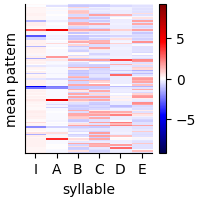

In [13]:
fig, ax = plt.subplots(1, figsize=(2,2))
v = np.abs(y_ctrl).max()
im = ax.imshow(y_ctrl.mean(axis=0), cmap='seismic', interpolation='none', vmin=-v, vmax=v)
ax.set(xlabel='syllable', ylabel='mean pattern', yticks=[],
       xticks=list(range(6)), xticklabels='IABCDE')
fig.colorbar(im, ax=ax, ticks=[-(v//2+1), 0, v//2+1])
# fig.savefig('../svg/supplementary/mean_sc_rep.svg')

Text(0.5, 0.98, 'Between-sample correlation')

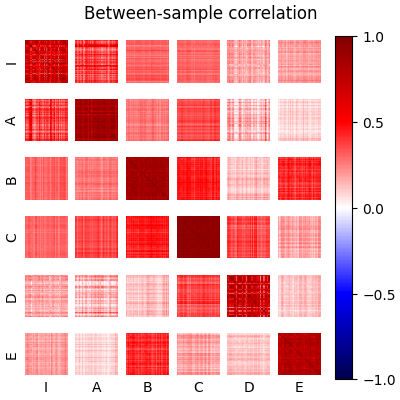

In [14]:
fig, ax = plt.subplots(y_ctrl.shape[-1], y_ctrl.shape[-1], figsize=(4,4))
for i in range(y_ctrl.shape[-1]):
    for j in range(y_ctrl.shape[-1]):
        im = ax[i,j].imshow(correlation(y_ctrl[...,i], y_ctrl[...,j]), 
                            vmin=-1, vmax=1, aspect=1, cmap='seismic')
        ax[i,j].set(xticks=[], yticks=[])
        ax[i,j].spines['left'].set(visible=False)
        ax[i,j].spines['bottom'].set(visible=False)
        ax[-1,j].set_xlabel('IABCDE'[j])
    ax[i,0].set_ylabel('IABCDE'[i])
fig.colorbar(im, ax=ax, ticks=[-1, -0.5, 0, 0.5, 1])
fig.suptitle('Between-sample correlation')
# fig.savefig('../svg/supplementary/between_sample_corr.svg')

[Text(0.5, 0, 'similarity with\ncorrect song'), Text(0, 0.5, 'density')]

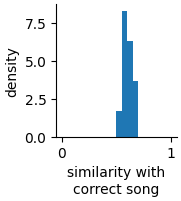

In [15]:
fig, ax = plt.subplots(1, figsize=(1.8, 2))
corr = correlation(y_ctrl[...,pert_syl_idx], y_pert[...,pert_syl_idx], dim=1, cosine=True) 
ax.hist(corr, bins=20, range=(0,1), density=True)
ax.set(xlabel='similarity with\ncorrect song', ylabel='density')
# fig.savefig('../svg/supplementary/similarity_song_perturb.svg')

In [16]:
song_T_max = 800 # ms
target_ts = np.arange(song_T_max) 
song_responses = dict(ctrl=np.zeros((*y_ctrl.shape[:2], len(target_ts))), 
                      pert=np.zeros((*y_pert.shape[:2], len(target_ts))))
# Make a filter to generate continuous responses
filt = np.exp(-np.linspace(0, 3, num=80)) #np.ones(50)
filt[:40] = 0
filt /= filt.sum()
# Get responses
for i in tqdm(range(y_ctrl.shape[0])): # batch
    ts = np.linspace(0, adult['song_Ts'][i], num=500)
    aux = np.zeros_like(ts)
    for j in range(y_ctrl.shape[1]):
        aux[:] = 0
        for k in range(n_syl):
            aux[(ts>=adult['syl_on'][i,k])&(ts<adult['syl_off'][i,k])] = y_ctrl[i,j,k]
        song_responses['ctrl'][i,j] = np.interp(target_ts, ts, aux, left=0, right=0)
        song_responses['ctrl'][i,j] = np.convolve(filt, song_responses['ctrl'][i,j], 'same')
        for k in range(n_syl):
            aux[(ts>=adult['syl_on'][i,k])&(ts<adult['syl_off'][i,k])] = y_pert[i,j,k]
        song_responses['pert'][i,j] = np.interp(target_ts, ts, aux, left=0, right=0)
        song_responses['pert'][i,j] = np.convolve(filt, song_responses['pert'][i,j], 'same')

100%|██████████| 60/60 [00:03<00:00, 15.14it/s]


<>:20: SyntaxWarning: invalid escape sequence '\ '
<>:20: SyntaxWarning: invalid escape sequence '\ '
/var/folders/bg/43fgzqj14377b2s2s0m5wfym0000gn/T/ipykernel_31194/3936008264.py:20: SyntaxWarning: invalid escape sequence '\ '
  ax[0].set(ylabel='$\ $\n', yticks=[4, 8])


Text(0.05, 0.1, 'Example output unit responses')

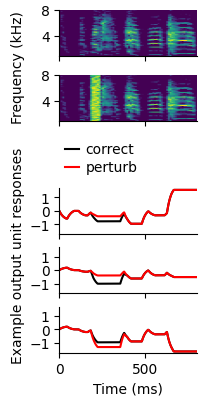

In [17]:
fig, ax = plt.subplots(6, 1, sharex='all', figsize=(2, 4))
i = 0
ax[0].imshow(adult['spec_song'][i], cmap='viridis', 
             extent=(0, adult['song_Ts'][i], 1, 8), origin='lower', aspect='auto')
ax[1].imshow(adult['spec_song_pert'][1][i], cmap='viridis', 
             extent=(0, adult['song_Ts'][i], 1, 8), origin='lower', aspect='auto')
# ax[0].vlines(adult['syl_on'][i], 1, 8, color='r')
# ax[0].vlines(adult['syl_off'][i], 1, 8, color='r', ls=':')
# ax[0].set_xlim([-50, 900])
for l in range(3):
    j = rng.integers(0,net.n_basis)
    ax[3+l].plot(song_responses['ctrl'][i,j].T, c='k')
    ax[3+l].plot(song_responses['pert'][i,j].T, c='r')
ax[2].plot(0, 0, c='k', label='correct')
ax[2].plot(0, 0, c='r', label='perturb')
ax[2].set_axis_off()
ax[2].legend(loc=(0,0))

ax[-1].set(xlabel='Time (ms)', xlim=[0, song_T_max])
ax[0].set(ylabel='$\ $\n', yticks=[4, 8])
ax[1].set(yticks=[4, 8])
ylim = (min([ax[i].get_ylim()[0] for i in range(3,6)]), 
        max([ax[i].get_ylim()[1] for i in range(3,6)]))
for i in range(3, 6):
    ax[i].set(ylim=ylim)
fig.text(0.05, 0.7, 'Frequency (kHz)', rotation=90)
fig.text(0.05, 0.1, 'Example output unit responses', rotation=90)
# fig.savefig('../svg/supplementary/example_sc_out.svg')

In [18]:
# comment out to save
# song_responses['pert_t0'] = adult['syl_on'][MASK_ADULT_TEST,pert_syl_idx]
# song_responses['pert_t1'] = np.minimum(adult['syl_on'][MASK_ADULT_TEST,pert_syl_idx]+50, \
#                                        adult['syl_off'][MASK_ADULT_TEST,pert_syl_idx])
# song_responses['sample_index'] = MASK_ADULT_TEST
# np.savez('learned_song_responses.npz', **song_responses)